**Установка pysparc**

In [1]:
!pip install pyspark

**Загрузка библиотек**

In [2]:
import pandas as pd
import numpy as np

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession 

sc = SparkContext('local') 
spark = SparkSession(sc)

**1. Загрузка данных при помощи spark.read.csv из приложенного файла.**

In [4]:
#header=True - Для чтения использует первую строку как имена столбцов. 
#inferSchema=True - При установке автоматически просматривает CSV-файл и выводит схему каждого столбца (тип столбца).
#quote="" - Для чтения, если вы хотите отключить кавычки, вам нужно задать не null а пустую строку. 

iris_df = spark.read.csv('iris.csv', header=True, inferSchema=True, quote="")

**2. Вывод 5 первых строк данных.**

In [5]:
#вывод 5 первых строк
iris_df.show(5)

+-------------+---------------+----------------+---------------+------------+
|"sepal.length|""sepal.width""|""petal.length""|""petal.width""|""variety"""|
+-------------+---------------+----------------+---------------+------------+
|         "5.1|            3.5|             1.4|            0.2| ""Setosa"""|
|         "4.9|            3.0|             1.4|            0.2| ""Setosa"""|
|         "4.7|            3.2|             1.3|            0.2| ""Setosa"""|
|         "4.6|            3.1|             1.5|            0.2| ""Setosa"""|
|           "5|            3.6|             1.4|            0.2| ""Setosa"""|
+-------------+---------------+----------------+---------------+------------+
only showing top 5 rows



In [6]:
#Типы атрибутов
iris_df.printSchema()

root
 |-- "sepal.length: string (nullable = true)
 |-- ""sepal.width"": double (nullable = true)
 |-- ""petal.length"": double (nullable = true)
 |-- ""petal.width"": double (nullable = true)
 |-- ""variety""": string (nullable = true)



In [7]:
#преобразуем названия колонок, без учета ''''
iris_df = iris_df.toDF("sepal_length","sepal_width","petal_length","petal_width","variety")
iris_df.show(5)

+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|    variety|
+------------+-----------+------------+-----------+-----------+
|        "5.1|        3.5|         1.4|        0.2|""Setosa"""|
|        "4.9|        3.0|         1.4|        0.2|""Setosa"""|
|        "4.7|        3.2|         1.3|        0.2|""Setosa"""|
|        "4.6|        3.1|         1.5|        0.2|""Setosa"""|
|          "5|        3.6|         1.4|        0.2|""Setosa"""|
+------------+-----------+------------+-----------+-----------+
only showing top 5 rows



In [9]:
#в значениях первого и последнего столбца удаляем лишние кавычки

from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType

undue_symbol = '["]'   #задаем символ для поиска и исключения
iris_df = iris_df.withColumn("sepal_length", regexp_replace(col("sepal_length"), undue_symbol, ''))\
    .withColumn("variety", regexp_replace(col("variety"), undue_symbol, ''))

iris_df.show(5)

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|variety|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| Setosa|
|         4.9|        3.0|         1.4|        0.2| Setosa|
|         4.7|        3.2|         1.3|        0.2| Setosa|
|         4.6|        3.1|         1.5|        0.2| Setosa|
|           5|        3.6|         1.4|        0.2| Setosa|
+------------+-----------+------------+-----------+-------+
only showing top 5 rows



In [10]:
#так как атрибут sepal.length имеет тип данных строка, то нужно переопределить тип в double

iris_df = iris_df.withColumn('sepal_length', col('sepal_length').cast(DoubleType()))
iris_df.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- variety: string (nullable = true)



In [11]:
#вывод итогового датасета после обработки 
iris_df.show(5)

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|variety|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| Setosa|
|         4.9|        3.0|         1.4|        0.2| Setosa|
|         4.7|        3.2|         1.3|        0.2| Setosa|
|         4.6|        3.1|         1.5|        0.2| Setosa|
|         5.0|        3.6|         1.4|        0.2| Setosa|
+------------+-----------+------------+-----------+-------+
only showing top 5 rows



**3. Используем команды groupBy, max, min и avg, чтобы вывести максимальное минимальное и среднее значение каждого из атрибутов цветка ('sepal_length','sepal_width','petal_length','petal_width').**

In [19]:
# Выводим основные стат. показатели 
iris_df.describe().show()

+-------+------------------+-------------------+------------------+------------------+---------+
|summary|      sepal_length|        sepal_width|      petal_length|       petal_width|  variety|
+-------+------------------+-------------------+------------------+------------------+---------+
|  count|               150|                150|               150|               150|      150|
|   mean| 5.843333333333335|  3.057333333333334|3.7580000000000027| 1.199333333333334|     null|
| stddev|0.8280661279778637|0.43586628493669793|1.7652982332594662|0.7622376689603467|     null|
|    min|               4.3|                2.0|               1.0|               0.1|   Setosa|
|    max|               7.9|                4.4|               6.9|               2.5|Virginica|
+-------+------------------+-------------------+------------------+------------------+---------+



In [166]:
# Группируем по типу/названию цветка и выводим стат. показатели

iris_size = iris_df.columns[:-1]   #выборка атрибутов размерности цветка  
iris_type = iris_df.columns[-1]    #выборка атрибута типа/названия цветка

for i in iris_size:
      iris_df.groupBy(iris_type)  \
      .agg(round((avg(i)),2).alias(f"avg({i})"),  \
           min(i),  \
           max(i))  \
      .show()

+----------+-----------------+-----------------+-----------------+
|   variety|avg(sepal_length)|min(sepal_length)|max(sepal_length)|
+----------+-----------------+-----------------+-----------------+
| Virginica|             6.59|              4.9|              7.9|
|    Setosa|             5.01|              4.3|              5.8|
|Versicolor|             5.94|              4.9|              7.0|
+----------+-----------------+-----------------+-----------------+

+----------+----------------+----------------+----------------+
|   variety|avg(sepal_width)|min(sepal_width)|max(sepal_width)|
+----------+----------------+----------------+----------------+
| Virginica|            2.97|             2.2|             3.8|
|    Setosa|            3.43|             2.3|             4.4|
|Versicolor|            2.77|             2.0|             3.4|
+----------+----------------+----------------+----------------+

+----------+-----------------+-----------------+-----------------+
|   variety|av

**4.Строим точечную диаграмму для petal_length и petal_width, раскрашенный по типам цветков.**

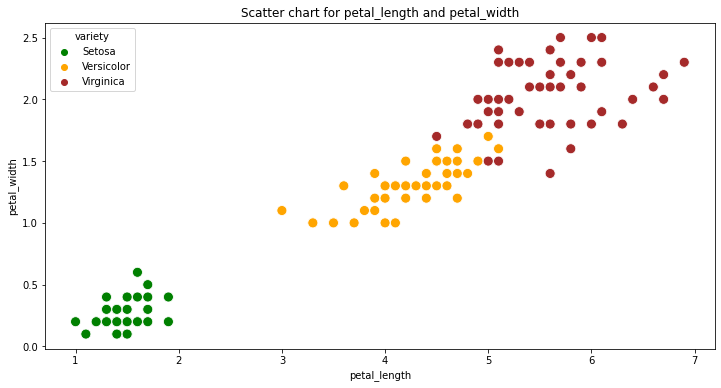

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

# Задаем размер графика
fig = plt.gcf()
fig.set_size_inches(12, 6)

# Конвертируем датафрейм в pandas
iris_df_pnd = iris_df.toPandas()

sns.scatterplot(data=iris_df_pnd, x="petal_length", y="petal_width", hue = "variety", palette=['green','orange','brown'], s=100) \
.set(title='Scatter chart for petal_length and petal_width');

**5.Смотрим внимательно на получившийся график и формируем правило вида ЕСЛИ ЗНАЧЕНИЕ ПАРАМЕТРА A < ЗНАЧЕНИЕ, ТО IRIS ОТНОСИТСЯ К КЛАССУ SETOSA -ИНАЧЕ К КАКОМУ-ТО ДРУГОМУ (НАЗОВЕМ, ЕГО НАПРИМЕР UNKNOWN).**

In [ ]:
# Условие для типа SETOSA по графику: если petal_length < 2 и petal_width < 1, то Setosa, в другом случае Others.

**6. При помощи команд withColumn, when, otherwise создаем в датафрейме новую колонку с таким предсказанием.**

In [112]:
#Добавляем в датафрейм новую колонку, если условие выполняется то вносим значение Setosa, иначе Others.

iris_df_pred = iris_df.withColumn("variety_pred", \
                                  when((iris_df.petal_length < 2) & (iris_df.petal_width < 1), \
                                       lit("Setosa")) \
                                  .otherwise(lit("Others")))                                    

iris_df_pred.show(5)

+------------+-----------+------------+-----------+-------+------------+
|sepal_length|sepal_width|petal_length|petal_width|variety|variety_pred|
+------------+-----------+------------+-----------+-------+------------+
|         5.1|        3.5|         1.4|        0.2| Setosa|      Setosa|
|         4.9|        3.0|         1.4|        0.2| Setosa|      Setosa|
|         4.7|        3.2|         1.3|        0.2| Setosa|      Setosa|
|         4.6|        3.1|         1.5|        0.2| Setosa|      Setosa|
|         5.0|        3.6|         1.4|        0.2| Setosa|      Setosa|
+------------+-----------+------------+-----------+-------+------------+
only showing top 5 rows



**7.Проверяем качество своего предсказания.**

Для этого:

7.1.Считаем количество строк, где предсказали класс Setosa и правильный класс был так же Setosa.

7.2.Считаем количество строк, где предсказали класс Setosa, а правильный класс был какой-то другой (воспользуйтесь оператором "не равно" -!=)

In [168]:
#Добавляем в датафрейм новую колонку c результатами корректности предсказания

iris_df_result = iris_df_pred.withColumn("pred_result", \
                                  when((col("variety") == "Setosa") & (col("variety_pred") == "Setosa"), \
                                       lit("Correct prediction")) \
                                  .when((col("variety") != "Setosa") & (col("variety_pred") == "Setosa"), \
                                       lit("Incorrect prediction")) \
                                  .otherwise(lit("No prediction")))                                    
iris_df_result.show(5)

#Считаем кол-во результатов предсказаний

iris_df_result.agg(count(when(col("pred_result") == "Correct prediction", True)) \
                  .alias('Setosa prediction is correct, rows count:')).show()
iris_df_result.agg(count(when(col("pred_result") == "Incorrect prediction", True)) \
                  .alias('Setosa prediction non correct, rows count:')).show()
iris_df_result.agg(count(when(col("pred_result") == "No prediction", True)) \
                  .alias('No prediction for Setosa, rows count:')).show()

+------------+-----------+------------+-----------+-------+------------+------------------+
|sepal_length|sepal_width|petal_length|petal_width|variety|variety_pred|       pred_result|
+------------+-----------+------------+-----------+-------+------------+------------------+
|         5.1|        3.5|         1.4|        0.2| Setosa|      Setosa|Correct prediction|
|         4.9|        3.0|         1.4|        0.2| Setosa|      Setosa|Correct prediction|
|         4.7|        3.2|         1.3|        0.2| Setosa|      Setosa|Correct prediction|
|         4.6|        3.1|         1.5|        0.2| Setosa|      Setosa|Correct prediction|
|         5.0|        3.6|         1.4|        0.2| Setosa|      Setosa|Correct prediction|
+------------+-----------+------------+-----------+-------+------------+------------------+
only showing top 5 rows

+-----------------------------------------+
|Setosa prediction is correct, rows count:|
+-----------------------------------------+
|              